<center>

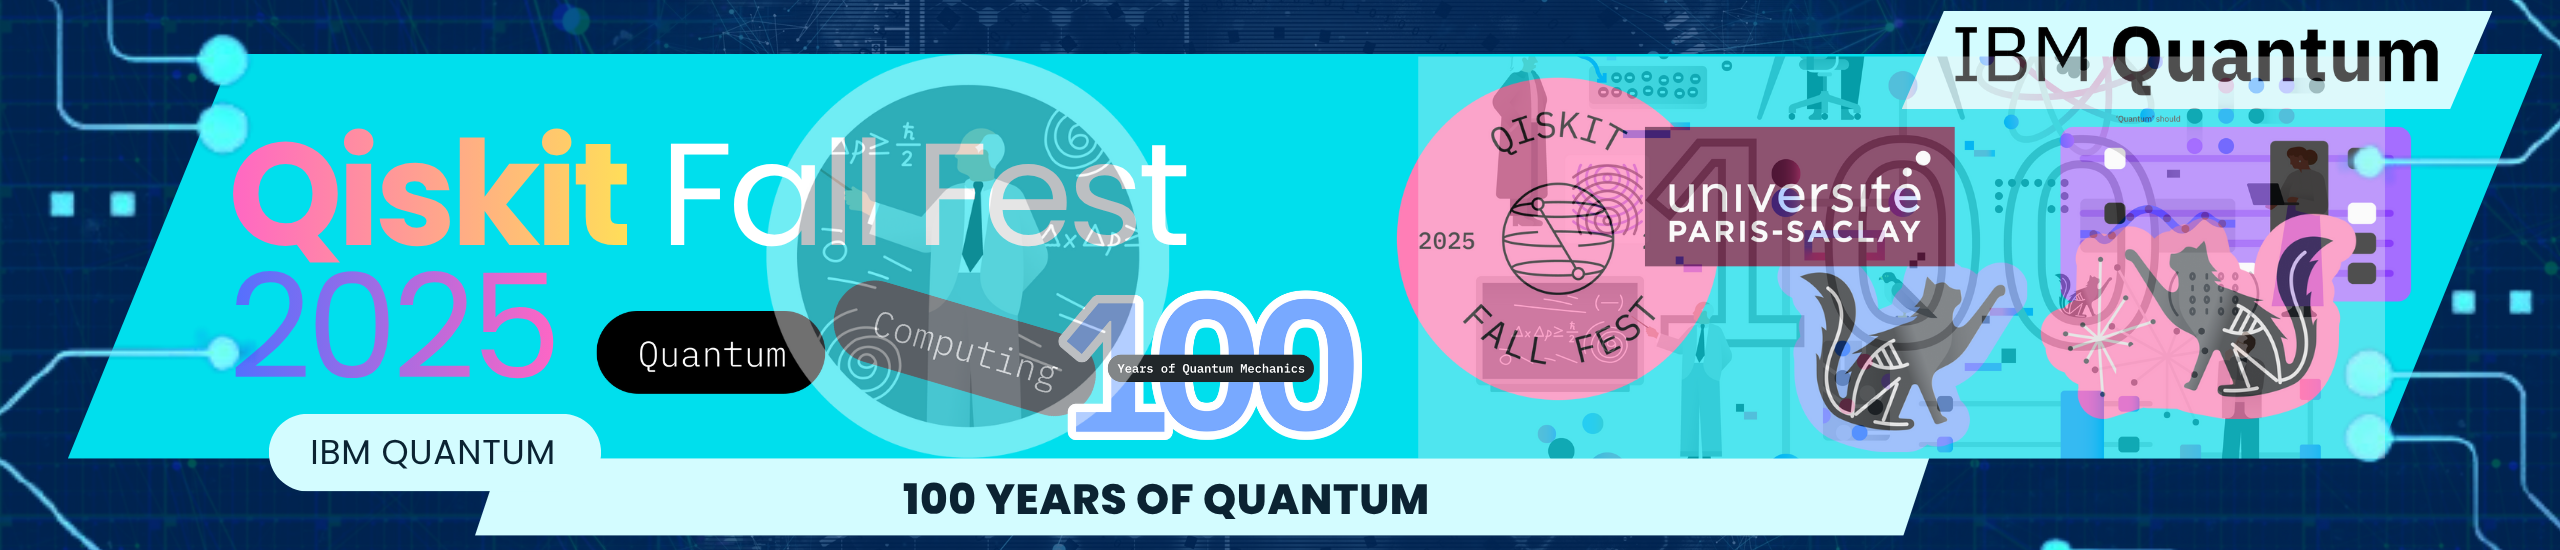

</center>

# 2025 Qiskit Fall Fest @ University Paris Saclay - Computing the Ground State Energy of Molecules by Sampling-based Quantum Diagonalizaton

- Difficulty level: Advanced
- Number of exercises: 6

<div class="alert alert-info">
This notebook is a practical implementation of the concepts taught in the <a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms" target="_blank">Quantum Diagonalization Algorithms course</a> on IBM Quantum Learning, more focused on comparing sampling capacities of different ansatz. For a deeper theoretical understanding of the methods used here, please refer to the course materials.
<br><br>
You will also find it helpful to reference:
    
* <a href="https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization">Sample-based quantum diagonalization of a chemistry Hamiltonian Tutorial</a>

* <a href="https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-krylov-quantum-diagonalization">Sample-based Krylov quantum diagonalization of a fermionic lattice model Tutorial</a>

* <a href="https://github.com/qiskit-community/qgss-2025/blob/main/lab-3/lab3.ipynb">QGSS 2025 Lab 3 notebook</a>
</div>

## Learning Objectives:
-   Understand the Sample-based Quantum Diagonalization (SQD) methods.
-   Analyze and compare how the choice of ansatz and initial parameters affects on SQD result.


## 0. Introduction

Finding the eigenvalues of large Hamiltonian matrices is a fundamental challenge in quantum mechanics and a key application for quantum computers. While classical exact diagonalization becomes computationally intensive for even small-size molecules, subspace methods offer a powerful alternative. By projecting the Hamiltonian onto a smaller, carefully chosen subspace that captures the essential physics, we can solve the problem on a classical computer. The crucial question then becomes: how do we construct this "useful" subspace?

This notebook explores a quantum approach for constructing this subspace to find the ground state energy of the dinitrogen ($N_2$) molecules.
Sample-based Quantum Diagonalization (SQD): This is a sampling-based approach where a quantum circuit, or ansatz, is used to prepare a trial state. By measuring this state in the computational basis, we sample a set of important configurations that are then used to define the subspace. The quality of the prepared quantum state is critical for the SQD method. A well-designed ansatz that reflects the underlying chemistry of the problem can generate a much more effective subspace than a generic one. To demonstrate this, we will systematically compare the performance of three different ansatz strategies for SQD, observing how accuracy improves with a more informed approach.

### Environment Setup

Before we begin our calculation, we need to prepare our computational environment. This involves importing all the necessary Python libraries for both classical chemistry calculations and quantum circuit execution.

 **Note**: Please make sure you have installed the latest version of Qiskit and the relevant packages.

In [ ]:
# Install the necessary packages

#%pip install -U ffsim 'qiskit[visualization]' qiskit-aer qiskit-ibm-runtime qiskit-addon-sqd pyscf

In [ ]:

import itertools
import warnings
from functools import partial

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
from math import comb
import pyscf
import pyscf.cc
import pyscf.mcscf
import scipy as sp

# Qiskit-related imports
import ffsim
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import BitArray, StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import (
    FakeFez,
    FakeTorino,
    FakeBrisbane
)

# SQD addon and utilities
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

warnings.filterwarnings("ignore")

## 1. Quantum chemistry calculation

### 1.1 Objective

The objective of this Lab is to learn the basics and general workflow of quantum chemistry calculations. You will also learn about a useful hybrid quantum-classical algorithm called Sample-based Quantum Diagonalization (SQD) algorithm. SQD is a classical post-processing technique which acts on samples obtained from a quantum circuit after execution on a QPU. It is useful for finding eigenvalues and eigenvectors of quantum operators, such as the Hamiltonian of a quantum system, and uses quantum and distributed classical computing together. 


### 1.2 What Are Atoms?
Everything around you is made of atoms—the tiny building blocks of matter. The word “atom” comes from a Greek word that means “can’t be split.” A long time ago, a man named Democritus thought that all things were made of tiny, unbreakable pieces called atoms.

In 1913, Niels Bohr said electrons move in circles (orbits) around the center of the atom, like planets around the sun. 
But in 1926, Erwin Schrödinger said electrons don’t really move in perfect paths. Instead, they buzz around in "clouds" where they’re most likely to be found.

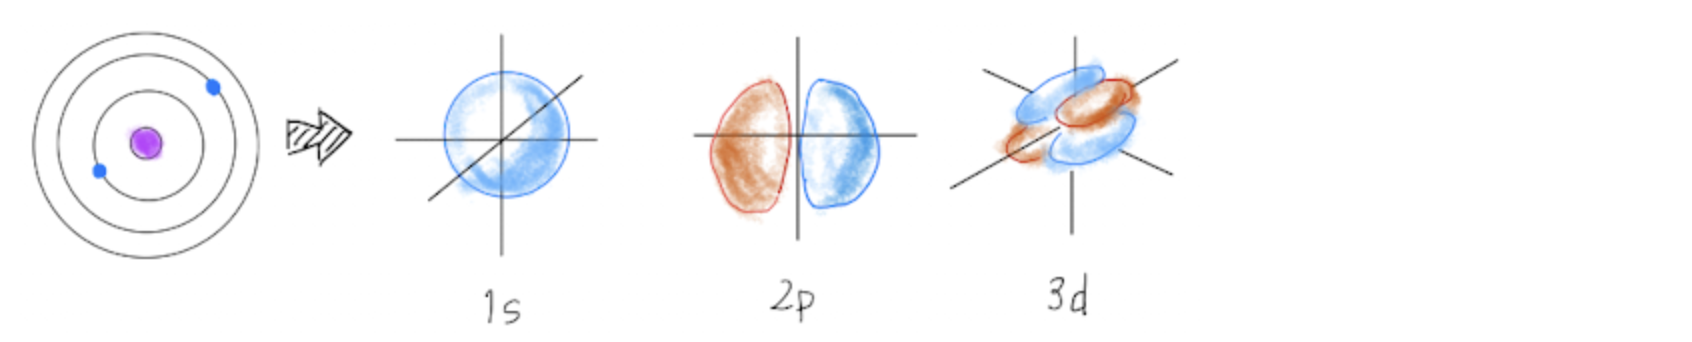

Fig 1. A sketch of Bohr’s atomic model (left) and Schrödinger’s atomic model based on quantum mechanical and wave nature of electrons (right).　 <br>


These clouds (called orbitals) have different shapes and energy levels. Electrons usually stay in the lowest energy level (the ground state), but they can jump to higher ones if they get energy. When they fall back down, they give off energy.

### 1.3 The Schrödinger Equation

Erwin Schrödinger's contributions to quantum mechanics go beyond introducing a new electronic model; he established the famous Schrödinger equation. The time-independent Schrödinger equation is:
$$
\hat{H}|\psi\rangle = {E}|\psi\rangle
$$

**$\hat{H}$**  : Hamiltonian operator <br>
**$|\psi\rangle$** : Wave function (state of the system) <br>
**${E}$** : Measured energy (eigenvalue) <br>

**The goal of quantum chemistry is to solve the Schrödinger Equation** for the wave function. The wave function that satisfies the Schrödinger Equation can help us find out interesting properties of that quantum system such as energy, momentum, spin, magnetization, and more. 

In quantum chemistry, we are often interested in finding **the ground state energy**. This is because once we know the ground state energy of a molecule, we can learn a lot such as:

- the shape a molecule will most likely take in a stable form. (often called the "equilibrium" state)
- how molecules might change or react during chemical reactions.
- how a drug might stick to a protein in the body seen in Docking simulations.
  
In short, finding the ground state is like finding the starting point for all the interesting things molecules can do.

But for big molecules, **solving the Schrödinger Equation exactly is extremely difficult** because the wave function, which describes the spatial distribution of electrons, is highly complex. So, instead of solving it perfectly, scientists make good guesses or approximations that are close enough.

### 1.4 Basis Set Approximation - Smart Building
One of the key approximations in quantum chemistry is the use  of a **basis set** approach. A basis set is **a collection of mathematical functions used to approximate the orbitals (wavefunctions) of electrons** in atoms and molecules. Since we can't solve the Schrödinger equation exactly for most systems, we use basis sets to make the problem computationally tractable. Instead of working with full, continuous atomic orbitals, we approximate them using a set of predefined mathematical functions—usually Gaussian-type or Slater-type orbitals.

This method is known as the Linear Combination of Atomic Orbitals (LCAO). The idea is simple: we build molecular orbitals by combining basis functions. It’s like building a complex shape using a sum of simpler, known shapes.
- A small basis set (fewer functions) gives a rough but fast approximation.
- A larger basis set improves accuracy but requires much more computational power.

<div class="alert alert-block alert-info"> 
<b>Types of Basis Functions</b><br>

- **Slater-type orbitals (STOs)**: These are mathematical functions that look very similar to real atomic orbitals (the shapes electrons naturally form around atoms). They describe how electron density drops off with distance from the nucleus.
- **Gaussian-type orbitals (GTOs)**: Easier to work with computationally, even though they don't resemble orbitals as closely. Often used in practice.</div>


The Slater-type orbital (STO) can be approximated by a combination of Gaussian-type orbitals (GTOs). In other words, we combine multiple Gaussians with different widths to mimic the shape of an STO. This combination is called a **contracted Gaussian function**. This idea is the basis for different kinds of basis sets, like minimal (simple) and split-valence (more accurate) sets.

- **Minimal Basis Set**:
A basis set that uses just one function per orbital (e.g., one function for $1s$, one for $2s$, etc.).
In STO-3G, for example, each STO is approximated using 3 Gaussians.
- **Split-Valence Basis Set**:
These are more flexible and provide more accurate representations than minimal basis sets.
They split the valence orbitals (the outermost orbital that contain electrons involved in bonding with other atoms) into two or more parts, each approximated with different combinations of Gaussians (like 6-31G).
This allows for better accuracy in chemical bonding and reactions.

### Common Basis Sets

|   Basis	Set    | Description	| Example Use | Computational Cost |
| ----------------- | ----------- | ----------- | ----------- |
| **STO-3G**	| Uses 3 Gaussians (the "3G") to mimic 1 STO. (aka 'Minimal basis')| Fast, rough estimate for small molecules| Low |
| **6-31G**	  | Uses 6 Gaussians to mimic 1 STO (the "6") for each core orbital. For each valence  (outer) orbital, a contracted function made of 3 Gaussians (the "3") and a single uncontracted Gaussian (the "1") are used.	| Good balance between speed and accuracy| Medium |
| **cc-pVDZ**	| Designed to improve electron correlation calculations. Adds polarization functions. Uses 2 basis functions for each valence orbitals instead of 1.	| More accurate than STO-3G and 6-31G when simulating systems that have stronger correlations, but more computationally expensive.| High |

> NOTE: The computational cost referred to in the table above is the classical cost of computing the molecular integrals. The more functions in your basis set, the more accurate your results—but computations take longer.

To summarize, instead of solving the full Schrödinger equation exactly (which is almost always impossible for molecules), we build a flexible, approximate wave function using known functions—and then tune it to minimize the system’s energy.

### 1.5 The Hamiltonian

At the heart of the Schrödinger equation, and to that extent in every quantum chemistry problem, there is a **Hamiltonian**. It’s a central object in both classical mechanics and quantum mechanics, and is essentially a function that represents the total energy (kinetic + potential) of a physical system.  

In quantum mechanics, the Hamiltonian $\hat{H}$ becomes an operator acting on the wave function $|\psi\rangle$. In a chosen basis, these wave functions $|\psi\rangle$ can be described as vectors and Hamiltonians in matrix form. 

In most quantum chemistry problems, the first and most important goal was to calculate its ground state energy. This calculation can be done by diagonalizing a Hamiltonian (matrix) and computing its eigenvalues and eigenvectors.

The size or dimensions of a molecular Hamiltonian can be determined by finding the number of combinations the electrons can occupy the spatial orbitals. This is essentially a combination problem that can quickly grow exponential in size making the diagonalization uncontractable for most interesting molecules. 

### Example: Calculate the size of the $N_2$ Hamiltonian
We would like you to get a sense of how large a Hamiltonian matrix $H$ can grow, even for a relatively small molecule like nitrogen ($N_2$), depending on how accurately you want to simulate it. In the following example, we chose the number of spatial orbitals, spin orbitals, and electrons of $N_2$ to use in our calculations. 

Using the number of spatial orbitals and electrons in the table below, let's compute the number of ways the electrons can occupy the spatial orbitals (spin configurations), which indicates the size of the $N_2$ molecule Hamiltonian.


|   |    STO-3G  |  6-31G  | cc-pVDZ  |  
|:-------|:------:|:-------:|:-------:|
|Spatial orbitals | (10) **8**| (18) **16** | (28) **26** |
|Spin orbitals | (20) **16**| (36) **32**| (56) **52** |
| α-spin electrons  | (7) **5**| (7) **5**| (7) **5** |
| β-spin electrons  | (7) **5**| (7) **5**| (7) **5** |


<p style="text-align:center;">Table 1: Number of orbitals and electrons in specified basis sets for $N_2$</p>

- (#) : number of orbitals and electrons we specifically chose for the purpose of this example.
- **#** : number of orbitals or electrons when freezing the core orbital (*1s*) and reducing the number of electrons and spatial orbitals each by 2.
<div class="alert alert-block alert-warning">
    
⚠️ **Note:** In this example we treat the $1s$ (core) orbital as chemically inactive. This means we can freeze the core orbital and save 2 electrons and 2 spatial orbitals (i.e. 4 spin orbitals -> 4 qubits). This is another useful approximation technique you will frequently see in actual chemistry simulations. Applying this technique, please make sure to use the numbers in **bold** for calculating for all possible electron configurations for the $N_2$ Hamiltonian.
</div>

As you can tell, solving for all possible spin configurations is essentially a combination problem. Let's take a look at the math to calculate how many ways the **$\alpha$-spin (spin-up)** electrons and **$\beta$-spin (spin-down)** electrons can each occupy given spatial orbitals. For the total spin configurations we simply need to multiply them together. 

<p style="text-align:center;">Total electron configurations = (total α-spin configurations) × (total β-spin configurations)</p>

$$ \Large{n}\Large{C}n_α \times n\Large{C}n_β = \Large\frac{n!}{n_α!(n-n_α)!} \times \Large\frac{n!}{n_β!(n-n_β)!}  $$

Where
**$n$**: number of spatial orbitals,
**$n_α$**: number of α-spins,
**$n_β$**: number of β-spins

Now that we know how to obtain the total spin configurations, let's calculate this in each basis set and plot the results to see how the size of the Hamiltonian grows with more accuracy.

In [ ]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

Note that the Y-axis above is in logarithmic scale. You can see how the number of spin configurations grows exponentially with a basis set choice of better approximation.

## 2. Problem Definition: The $N_2$ Molecule


### 2.1 Classical quantum chemistry calculation

To test and compare our quantum algorithms, we will use the dinitrogen ($N_2$) molecule, a common benchmark system in quantum chemistry. Before running quantum algorithms, let's use `PySCF` to perform a classical quantum chemistry calculations:

* [Self-Consistent Field (SCF)](https://pyscf.org/user/scf.html) calculation: We first perform an SCF calculation to find the Hartree-Fock state (a baseline approximation of the ground state). This also provides the one- and two-body integrals (`hcore` and `eri`), which we will later use to construct the Hamiltonian.
* [Full Configuration Interaction (FCI)](https://pyscf.org/user/ci.html#full-configuration-interaction-fci) calculation: We then run an FCI calculation within the active space (known as CASCI) to get the numerically "exact" ground state energy for our chosen basis set, which serves as our benchmark.
* [Coupled-Cluster Single and Doubles (CCSD)](https://pyscf.org/user/cc.html) calculation: We also run a CCSD calculation to obtain the [t-amplitudes](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.79.291#s3) (t1 and t2). These amplitudes, which quantify electron excitations, provide an excellent, physically-motivated initial guess for the parameters of our chemistry-inspired ansatz.

**Note** For more details of each chemical method and `PySCF` itself, please refer [The Python-based Simulations of Chemistry Framework (PySCF)](https://arxiv.org/abs/1701.08223), the original paper about the `pyscf` package for your own deeper study. In general, "Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory" by Attila Szabo and Neil S. Ostlund is recommended as a good textbook to learn about each method in details, but this can be a graduate level study, and we won't cover each details here.

In [ ]:
#Define molecule

mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="sto-6g",
    symmetry="dooh"

)

We will now define an active space. This technique involves "freezing" the core orbitals (electrons very close to the nuclei) and discarding the highest-energy virtual orbitals, as they contribute less to the chemical bonding and correlation. This allows us to focus our simulation on the most important valence electrons, reducing the number of qubits required. For this $N_2$ problem, we will simulate 8 spatial orbitals with 10 active electrons, which translates to a 16-qubit problem.


<div class="alert alert-success">
    <h4>Exercise 1: Defining the Active Space and get a molecular property of N2</h4>
    <p>For the N₂ molecule with a <code>sto-6g</code> basis set, there are 10 total molecular orbitals. To reduce computational cost, we will "freeze" the two lowest-energy core orbitals and use the remaining 8 orbitals as our <b>active space</b>.</p>
    <p>In the code cell below, calculate and fill in the following variables:</p>
    <ul>
        <li><code>num_orbitals</code>: The number of spatial orbitals in the active space.</li>
        <li><code>n_electrons</code>: The total number of electrons in the active space.</li>
        <li><code>num_elec_a</code>: The number of alpha (spin-up) electrons in the active space.</li>
        <li><code>num_elec_b</code>: The number of beta (spin-down) electrons in the active space.</li>
    </ul>
    <p><b>Hint:</b> <code>scf.mo_occ</code> is an array containing the occupation (0, 1, or 2) of each molecular orbital. You can use this array, indexed by the <code>active_space</code>, to count the electrons. Since dinitrogen is a closed-shell system, the number of alpha and beta electrons will be equal.</p>
</div>

In [ ]:
# --- Perform Self-Consistent Field (SCF) Calculation ---
scf = pyscf.scf.RHF(mol).run()

n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
num_orbitals = len(active_space)

# --- Determine Number of Alpha and Beta Electrons ---
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
nelec = (num_elec_a, num_elec_b)
num_qubits = 2 * num_orbitals

print(f"Number of active spatial orbitals: {num_orbitals}")
print(f"Number of active electrons: {n_electrons}")
print(f"Number of alpha electrons: {num_elec_a}")
print(f"Number of beta electrons: {num_elec_b}")
print(f"Number of qubits: {num_qubits}")


converged SCF energy = -108.464957764796
Number of active spatial orbitals: 8
Number of active electrons: 10
Number of alpha electrons: 5
Number of beta electrons: 5
Number of qubits: 16


Then, FCI calculation to get the `exact_fci_energy` of our molecule.

In [ ]:
# Calculate molecular integrals and FCI benchmark

cas = pyscf.mcscf.CASCI(scf, num_orbitals, nelec)
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
fci_result = cas.run(mo)
exact_fci_energy = fci_result.e_tot

print(f"\nExact total ground state energy (FCI): {exact_fci_energy:.6f} Ha")


CASCI E = -108.595987350986  E(CI) = -32.4115475088426  S^2 = 0.0000000

Exact total ground state energy (FCI): -108.595987 Ha


Finally, a CCSD calculation to get a `t1` and `t2`

In [ ]:
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run(verbose=0)

t1 = ccsd.t1
t2 = ccsd.t2

### 2.2 Qubit Hamiltonian Mapping

<div class="alert alert-success">
    <h4>Exercise 2: Convert molecule into qubit operator</h4>
    <p>Quantum computers operate on qubits, so the fermionic Hamiltonian, which is expressed in terms of electron creation and annihilation operators, must be mapped to a qubit operator (a sum of Pauli strings). The <b>Jordan-Wigner transformation</b> is used for this mapping.</p>
    <p>Using the <code>ffsim</code> library, first get the molecular hamiltonian(mol_hamiltonian) by using <code>ffsim.MolecularHamiltonian</code>.  Then get the <code>ferm_op</code> (a <code>FermionOperator</code> object) by using <code>ffsim.fermion_operator</code> and call the <code>ffsim.qiskit.jordan_wigner</code> function on it to generate <code>hamiltonian_op</code> which should be a Qiskit <code>SparsePauliOp</code> object.</p>

</div>


<div class="alert alert-info">
Mapping a physical or optimization problem to qubits is typically a non-trivial task. While the specific details of these mappings are not the focus of this particular notebook, you can find more information in other IBM Quantum Learning courses.
<br>
<ul>
    <li>A general discussion of mapping a problem to a quantum operator can be found in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-computing-in-practice" target="_blank">Quantum computing in practice course</a></b>.</li>
    <li>A more detailed look at the mapping of chemistry problems into quantum operators can be found in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe" target="_blank">Quantum Chemistry with VQE course</a></b>.</li>
</ul>
</div>

In [ ]:
#N2
mol_hamiltonian = ffsim.MolecularHamiltonian(one_body_tensor=hcore, two_body_tensor=eri)
ferm_op = ffsim.fermion_operator(mol_hamiltonian)
hamiltonian_op = ffsim.qiskit.jordan_wigner(ferm_op)

## 3. Main Method: Sample-based Quantum Diagonalization (SQD)

<div class="alert alert-info">
<b>Prerequisite:</b>
    
For a detailed theoretical background on SQD, we highly recommend watching the video above and reviewing the material in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-overview" target="_blank">SQD overview</a></b> and <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-implementation" target="_blank">SQD implementation</a></b> lessons.
    
This notebook focuses on the practical application and will skip the in-depth theoretical explanations.
</div>


In [ ]:
from IPython.display import IFrame, display

display(IFrame('https://video.ibm.com/embed/recorded/134325501', width=800, height=600))


SQD is a powerful variational algorithm that builds a subspace by sampling from a trial wavefunction prepared by a parameterized quantum circuit, known as an ansatz. The general workflow of SQD is as follows:

1.  Quantum Step: An ansatz circuit is executed on the quantum computer to prepare a trial state $|\Psi(\theta)\rangle$. This state is measured in the computational basis many times to generate a collection of bitstrings (configurations).
2.  Classical Step: A selection of the most significant configurations from the measurement results is used to form a basis for a small subspace. The full Hamiltonian is then projected onto this subspace and diagonalized classically to find its lowest eigenvalue. Instead of a complex manual classical post-processing loop, we will use the `diagonalize_fermionic_hamiltonian` function from the `qiskit-addon-sqd` package. This high-level function automatically handles the subspace construction, diagonalization, and optional self-consistent configuration recovery. This recovery process iteratively uses the solution from the previous diagonalization to sample new, more relevant configurations, thus refining the subspace and improving the final energy.

The effectiveness of SQD is highly dependent on the quality of the ansatz. A good ansatz should be able to represent the true ground state with high fidelity. In this chapter, we will investigate this dependency by running the SQD algorithm with three different ansatz strategies, from generic to highly informed.

### 3.1. Baseline: Hardware-Efficient Ansatz (`RealAmplitudes`) with a Random Initial State and Parameters

We begin with a generic, hardware-efficient ansatz: Qiskit's `RealAmplitudes` circuit. This type of ansatz is constructed using layers of single-qubit Y-rotations and CNOT gates, making it easy to implement on most quantum hardware. However, it lacks any specific chemical intuition. We will initialize quantum circuit by randomly selecting qubits with electrons and then initialize the parameters of this ansatz also randomly to establish a baseline performance for SQD when using a generic circuit without any prior chemical knowledge, except the number of active electrons.

#### Step 1: Circuit Construction

First, we import the `RealAmplitudes` ansatz from Qiskit's circuit library. Next, we build the full quantum circuit. We start with the `Hartree-Fock` state, then append the `RealAmplitudes` ansatz. The parameters of the ansatz are initialized with random values between 0 and $2\pi$. Finally, we add measurements to all qubits.

<div class="alert alert-success">
    <h4>Exercise 3: Create a Hardware-Efficient Ansatz (<code>RealAmplitudes</code>) for SQD</h4>
    <p>For our first experiment, we will use a <b>hardware-efficient ansatz</b> with a generic structure. Qiskit's <code>RealAmplitudes</code> from the circuit library is well-suited for this purpose.</p>
    <p>Perform the following tasks below:</p>
    <ol>
        <li>Call the <code>RealAmplitudes</code> function to create an ansatz for 16 qubits with 2 repetitions (reps).</li>
        <li>Append the created ansatz to the main <code>circuit_ra</code> object using <code>circuit_ra.append()</code>. It should be assigned the parameters from the pre-generated <code>params_ra</code> array.</li>
    </ol>
</div>

In [ ]:

#7s, ibm_pittsburg

# Create RealAmplitudes ansatz
reps_ra = 2 # Number of repetitions
rng = np.random.default_rng()


# Construct the full circuit
qr_main = QuantumRegister(num_qubits)
circuit_ra = QuantumCircuit(qr_main)

#circuit_ra.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), range(num_qubits)) #try a HartreeFock init sate
random_index = rng.choice(num_orbitals, size=num_elec_a, replace=False)
for i in random_index:
    circuit_ra.x(qr_main[i])
    circuit_ra.x(qr_main[num_orbitals + i])

# RealAmplitude Ansatz
ansatz_ra = RealAmplitudes(num_qubits, reps=reps_ra)
params_ra = rng.uniform(0, 2 * np.pi, ansatz_ra.num_parameters)


circuit_ra.append(ansatz_ra.assign_parameters(params_ra), qr_main)


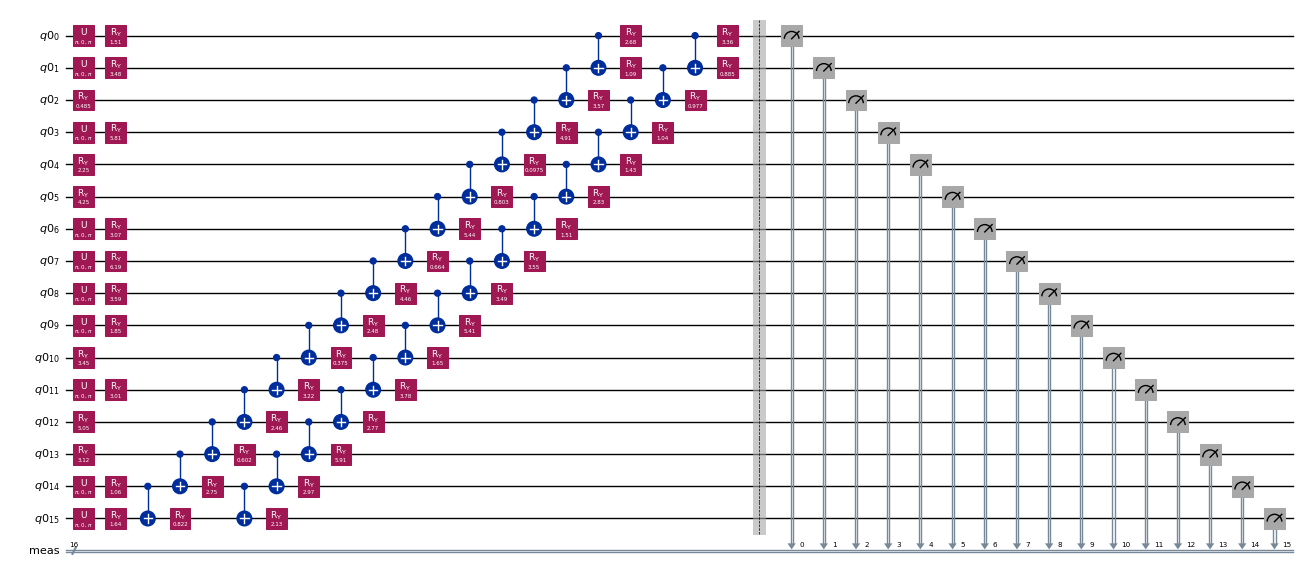

In [ ]:
circuit_ra.measure_all()
circuit_ra.decompose(reps=2).draw("mpl", scale=0.5, fold=-1)

#### Step 2: Execute Circuit

We run circuit using the Sampler and collect 1024 measurement samples (shots).

In [ ]:
# Backend
sampler = StatevectorSampler(default_shots=1024)
# Execute using Sampler
job_ra = sampler.run([circuit_ra])
print(job_ra.result())

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=16>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


#### Step 3: Post-process and analyze results

We retrieve the results from the sampler running and use the `diagonalize_fermionic_hamiltonian` function to perform the SQD analysis. We set the number of self-consistent recovery iterations to 5 and use 50 samples per batch for the classical diagonalization.

In [ ]:
result_ra = job_ra.result()
pub_result_ra = result_ra[0]
bit_array_ra = pub_result_ra.data.meas

In [ ]:
# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 50
symmetrize_spin = True
carryover_threshold = 1e-3
max_cycle = 20

#create sci solver with options
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


In [ ]:
# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ra,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)


Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [ ]:
#plot function
def plot_sqd_results(result: SCIResult, result_history: list):
    """
    Analyzes, plots, and returns the results of an SQD experiment.

    Args:
        result: The final SCIResult object from the converged SQD calculation.
        result_history: A list of SCIResult objects from each SQD iteration.

    Returns:
        A tuple containing:
        - energy_errors (list): The absolute energy error at each iteration.
        - fig (matplotlib.figure.Figure): The figure object for the plots.
        - axs (numpy.ndarray): The axes objects for the subplots.
    """

    iterations = range(len(result_history))
    min_energies = [
        min(res_list, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for res_list in result_history
    ]
    energy_errors = [abs(e - exact_fci_energy) for e in min_energies]

    chem_accuracy = 0.0016

    avg_occupancies = np.sum(result.orbital_occupancies, axis=0)
    orbital_indices = range(len(avg_occupancies))

    final_sqd_energy = result.energy + nuclear_repulsion_energy

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(iterations, energy_errors, label="Energy Error", marker="o")
    axs[0].set_xticks(iterations)
    axs[0].set_xticklabels([i + 1 for i in iterations])
    axs[0].set_yscale("log")
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="Chemical Accuracy")
    axs[0].set_title("Ground State Energy Error vs. SQD Iterations")
    axs[0].set_xlabel("Configuration Recovery Iteration")
    axs[0].set_ylabel("Absolute Energy Error (Hartree)")
    axs[0].legend()
    axs[0].grid(True, which="both", ls="--", alpha=0.5)

    axs[1].bar(orbital_indices, avg_occupancies, width=0.8)
    axs[1].set_xticks(orbital_indices)
    axs[1].set_title("Avg. Occupancy per Spatial Orbital (Final Result)")
    axs[1].set_xlabel("Orbital Index")
    axs[1].set_ylabel("Avg. Occupancy")
    axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)

    print("--- SQD Results ---")
    print(f"Exact energy: {exact_fci_energy:.5f} Ha")
    print(f"Final SQD energy: {final_sqd_energy:.5f} Ha")
    print(f"Final Absolute error: {energy_errors[-1]:.5f} Ha\n")

    plt.tight_layout()

    # Return the error data and plot objects for later use
    return energy_errors, fig, axs

# # Example of how to call the function and capture the returned values:
# errors, fig, axs = plot_sqd_results(result, result_history)
# plt.show() # You would call this to display the plot


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59497 Ha
Final Absolute error: 0.00102 Ha



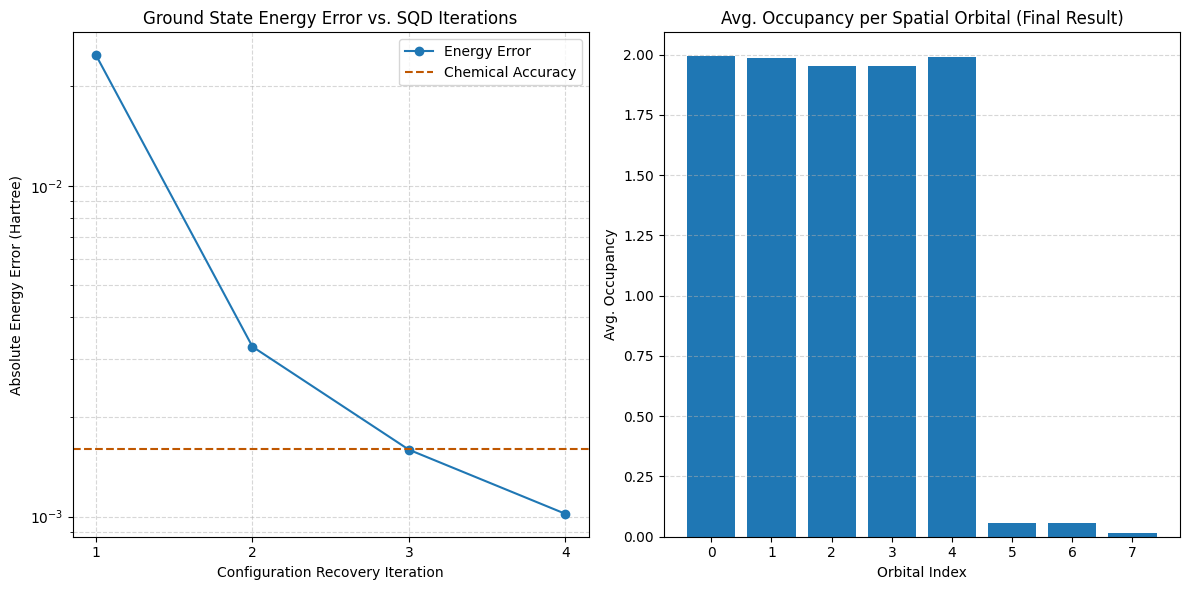

In [ ]:
e_diff_ra, fig, axs = plot_sqd_results(result, result_history)
plt.show()

### 3.2. Chemistry-Inspired UCJ with a Random Initial State and Parameters

Next, we move to a more sophisticated, chemistry-inspired ansatz: the **Unitary Cluster Jastrow (UCJ)** operator ansatz. The structure of this ansatz is derived from coupled-cluster theory. It is specifically designed to capture the electron correlation effects that are crucial for accurately describing molecular systems.

#### Step 1: Circuit Construction
Because its structure is tailored to the physics of the problem, the UCJ ansatz is expected to be much more expressive and efficient at representing the $N_2$ ground state than the generic `RealAmplitudes` circuit. To ensure a fair comparison with the previous step, we will again initialize the UCJ ansatz with randomly selected qubits and random parameters.

In [ ]:
#7s ibm_fez

n_reps = 2

alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

num_params_ucj = ffsim.UCJOpSpinBalanced.n_params(
    num_orbitals, n_reps, interaction_pairs=(alpha_alpha_indices, alpha_beta_indices)
)
print(f"Number of parameters for UCJ ansatz: {num_params_ucj}")

random_params_ucj = rng.uniform(0, 2 * np.pi, num_params_ucj)

ucj_op_random = ffsim.UCJOpSpinBalanced.from_parameters(
    random_params_ucj,
    norb=num_orbitals,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

#qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit_ucj_rand = QuantumCircuit(qr_main)


random_index = rng.choice(num_orbitals, size=num_elec_a, replace=False)
for i in random_index:
    circuit_ucj_rand.x(qr_main[i])
    circuit_ucj_rand.x(qr_main[num_orbitals + i])

#circuit_ucj_rand.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qr_main) #try hartree-fock initial state to compare

circuit_ucj_rand.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op_random), qr_main)
circuit_ucj_rand.measure_all()

Number of parameters for UCJ ansatz: 146


#### Step 2: Execute UCJ circuit
The UCJ circuit is submitted to the sampler.

In [ ]:
sampler = StatevectorSampler()

job_ucj_rand = sampler.run([circuit_ucj_rand], shots=10000)
print(job_ucj_rand.result())

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=16>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})


#### Step 3: Post-process and analyze results
The results from the UCJ experiment are retrieved.


In [ ]:
result_ucj_rand = job_ucj_rand.result()
pub_result_ucj_rand = result_ucj_rand[0]
bit_array_ucj_rand = pub_result_ucj_rand.data.meas

In [ ]:
#sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ucj_rand,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)

Iteration 1
Iteration 2
Iteration 3
Iteration 4


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59596 Ha
Final Absolute error: 0.00003 Ha



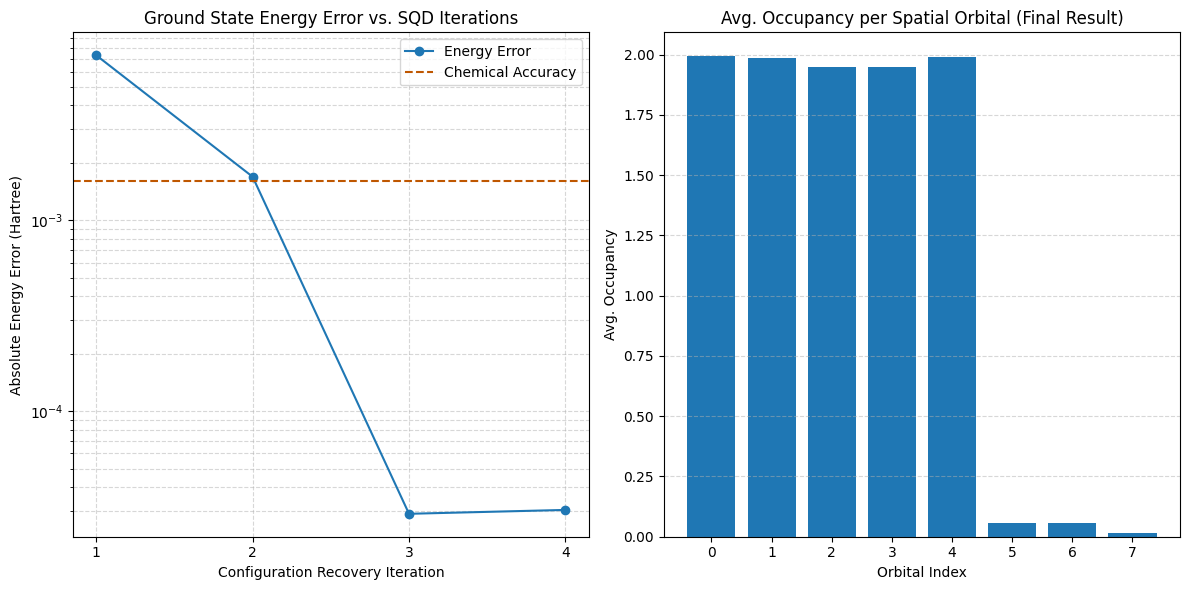

In [ ]:
e_diff_rand, fig, axs = plot_sqd_results(result, result_history)
plt.show()

<div class="alert alert-info">
    
**For your Deeper Study**

So far, we used random initial initial state and parameters for both - RealAmplitude and UCJ - ansatz and computed the ground state with one calculation.

1. Try to initialize ansatz with `Hartree Fock` state and compare it with our random initialized ansatz.
2. As SQD is a variational algorithm, can you design a feedback loop to update and optimize these initial parameters for a better final result? You can use the computed ground state energy as a cost function of this feedback loop.

</div>

### 3.3. The Informed Approach: UCJ Ansatz with CCSD Initial Parameters and Hartree-Fock State

In our most informed approach, we combine the power of the chemistry-inspired UCJ ansatz with insights from our classical calculations. Instead of using a random initial state and parameters, we will initialize the UCJ operator using the **t-amplitudes** from our earlier classical CCSD calculation. The circuit will be prepared in the Hartree-Fock state before UCJ operator is applied.

This strategy tests the central hypothesis of many variational algorithms: that a good ansatz, when guided by good initial parameters from a classical approximation, will yield the most accurate and efficient results.

#### Step 1: Map problem to quantum circuits and operators
This is the key step. We construct the `UCJOpSpinBalanced` ansatz again, but this time we initialize it using the `t1` and `t2` amplitudes from our classical CCSD calculation performed in Chapter 1, instead of random parameters.


<div class="alert alert-success">
    <h4>Exercise 4: Initialize an Informed UCJ Ansatz</h4>
    <p>Use the <code>ffsim.UCJOpSpinBalanced.from_t_amplitudes()</code> function to create the <code>ucj_op</code> below. This function directly accepts the <code>t1</code> and <code>t2</code> amplitudes from the CCSD calculation as input.</p>
    <b> Hint </b>: <a href = https://qiskit-community.github.io/ffsim/how-to-guides/qiskit-lucj.html> This ffsim tutorial </a> will be very helpful.
</div>

In [ ]:
n_reps = 2

# Use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(num_orbitals - 1)]
pairs_ab = [(p, p) for p in range(num_orbitals)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    ccsd.t2,
    t1=ccsd.t1,
    n_reps=n_reps,
    interaction_pairs=(pairs_aa, pairs_ab),
    # Setting optimize=True enables the "compressed" factorization
    optimize=True,
    options=dict(maxiter=100),
)

# Construct circuit
qubits = QuantumRegister(num_qubits)
circuit_ucj_inform = QuantumCircuit(qubits)
circuit_ucj_inform.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit_ucj_inform.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit_ucj_inform.measure_all()

#### Step 2: Execute circuit

In [ ]:
sampler = StatevectorSampler()
job_ucj_inform = sampler.run([circuit_ucj_inform], shots=10000)
print(job_ucj_inform.result())

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=16>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})


####  Step 3: Post-process and analyze results

In [ ]:
result_ucj_inform = job_ucj_inform.result()
pub_result_ucj_inform = result_ucj_inform[0]
bit_array_ucj_inform = pub_result_ucj_inform.data.meas

In [ ]:
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ucj_inform,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)

Iteration 1
Iteration 2
Iteration 3


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59387 Ha
Final Absolute error: 0.00211 Ha



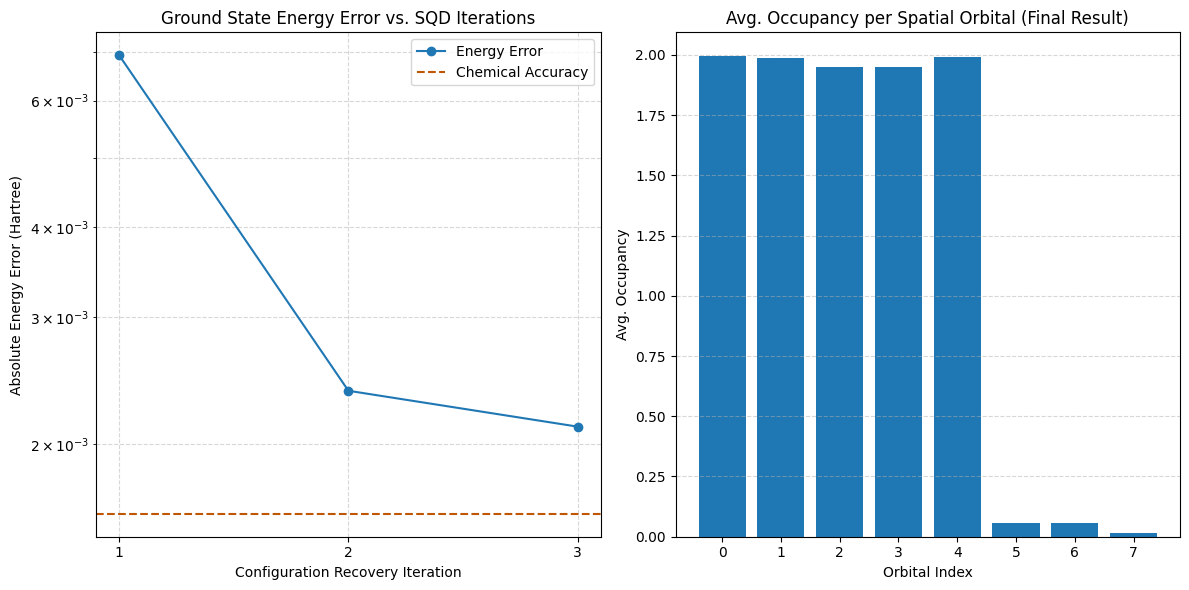

In [ ]:
e_diff_ucj_inform, fig, axs = plot_sqd_results(result, result_history)
plt.show()

## 5. Compare Results

<div class="alert alert-success">
    <h4>Congratulations! &#127881;</h4>
    </div>

You have successfully calculated the ground state energy of the $N_2$ molecule using advanced quantum algorithms. You've seen firsthand how a diagonalization-based quantum approach, combining insights from classical chemistry with the power of quantum sampling, can achieve meaningful accuracy.


In this notebook, we explored two powerful quantum methods SQD, to determine the ground state energy of the $N_2$ molecule using different strategies. The results, summarized in the comparison plot below, clearly demonstrate the strengths and trade-offs of each approach, leading to a compelling conclusion: for quantum chemistry simulations on near-term devices, a physically-motivated ansatz initialized with classical chemical insight potentially provides an advantage.

Our investigation showed a systematic improvement in accuracy as we refined our SQD strategy:

1.  Baseline: The generic `RealAmplitudes` ansatz established a performance baseline. While it demonstrated convergence, its final error was the largest among all approaches, highlighting the limitations of a hardware-efficient but chemically unaware ansatz.


2.  Improved Ansatz Structure: Switching to the chemistry-inspired `UCJ` ansatz, even with random parameters, yielded an improvement, converging to a result well within chemical accuracy. This demonstrates the power of choosing an ansatz structure that reflects the underlying physics of the problem

3.  The Informed Approach: Initializing the `UCJ` ansatz with t-amplitudes from a classical CCSD calculation also achieved a high degree of accuracy. This "informed" approach confirms that quantum algorithms can perform well when their state preparation is guided by classical approximations.

Ultimately, all chemistry-inspired methods (UCJ with random or informed parameters) far outperformed the generic ansatz. The small differences in final energy between them are likely within the statistical noise of the device and limitation of a simple basis-set, confirming that multiple pathways exist to achieve high accuracy in quantum chemistry simulations.


### Comparison Plot

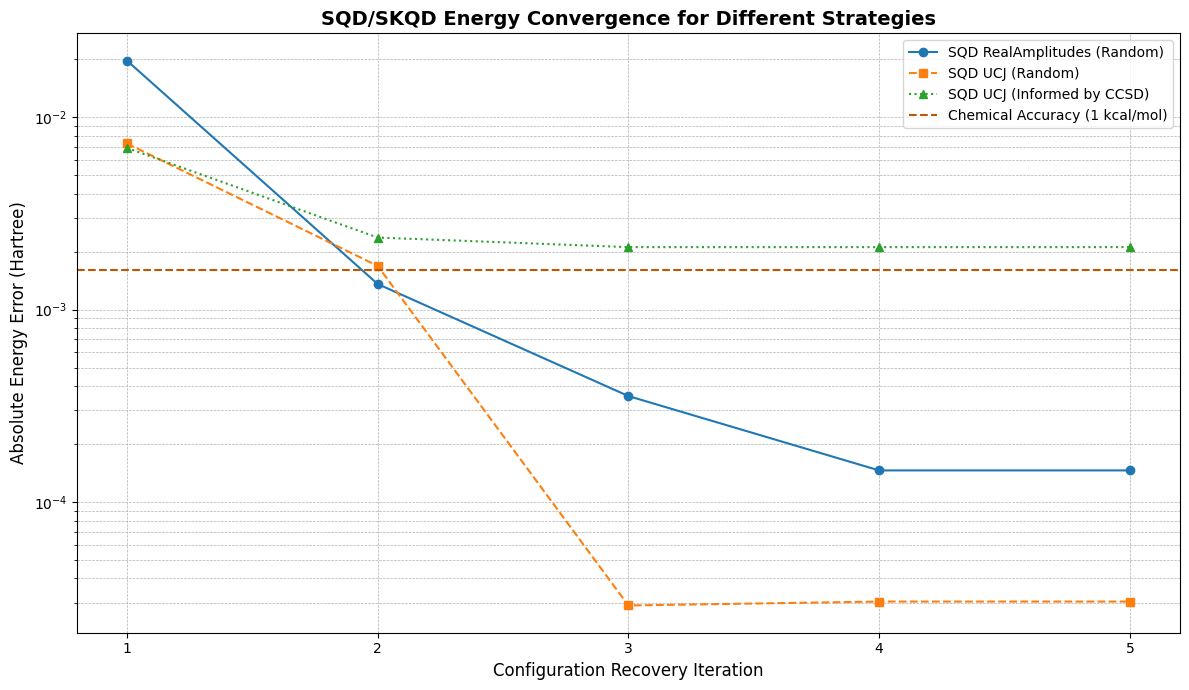

In [ ]:
# --- Configuration ---
plot_data = [
    {
        "label": "SQD RealAmplitudes (Random)",
        "errors": e_diff_ra,
        "marker": "o",
        "linestyle": "-",
        "color": "C0"
    },
    {
        "label": "SQD UCJ (Random)",
        "errors": e_diff_rand,
        "marker": "s",
        "linestyle": "--",
        "color": "C1"
    },
    {
        "label": "SQD UCJ (Informed by CCSD)",
        "errors": e_diff_ucj_inform,
        "marker": "^",
        "linestyle": ":",
        "color": "C2"
    }
]
MAX_ITERATIONS = 5
CHEM_ACCURACY = 0.0016  # 1 kcal/mol

# --- Helper Function for Data Padding ---
def pad_data(error_list, target_length):
    """Pads an error list with its last value to a target length."""
    last_value = error_list[-1] if error_list else 0
    padding = [last_value] * (target_length - len(error_list))
    return error_list + padding

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 7))
for data in plot_data:
    padded_errors = pad_data(data["errors"], MAX_ITERATIONS)
    ax.plot(
        range(MAX_ITERATIONS),
        padded_errors,
        label=data["label"],
        marker=data["marker"],
        linestyle=data["linestyle"],
        color=data["color"]
    )

ax.axhline(
    y=CHEM_ACCURACY,
    color="#BF5700",  # A distinct color
    linestyle="--",
    label="Chemical Accuracy (1 kcal/mol)"
)
# --- Formatting and Labels ---
ax.set_yscale("log")
ax.set_ylabel("Absolute Energy Error (Hartree)", fontsize=12)
ax.set_xlabel("Configuration Recovery Iteration", fontsize=12)
ax.set_title("SQD Energy Convergence for Different Strategies", fontsize=14, fontweight='bold')
ax.set_xticks(range(MAX_ITERATIONS))
ax.set_xticklabels([i + 1 for i in range(MAX_ITERATIONS)]) # Label iterations starting from 1
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
    
**For your Deeper Study**

If you have a computer with sufficient memory (more than 64GB), we recommend you try a different basis set—`6-31g`—with both an ideal simulator and a real backend and compare our different strategies. Please be sure to also compare the new CASCI energy computed for that basis set.


**Questions for Further Exploration**

- Ansatz Suitability: Why does the UCJ ansatz, even with random parameters, generally outperform the hardware-efficient RealAmplitudes ansatz for this chemistry problem? What structural features of UCJ make it more suitable for capturing electron correlation?
- Overall Efficiency: The "informed" UCJ was the most accurate (but can differ by runs). Was it the most efficient overall? Consider the total computational cost, including the classical CCSD calculation time plus the quantum execution time.
- SQD vs. SKQD: The SKQD circuit was noted to be very deep. Under what conditions might SKQD be a better choice than a variational method like SQD?
- Problem Scaling: How would the resource requirements (qubits, circuit depth) and the impact of noise change if you were to simulate a slightly larger molecule, like water ($H_2O$), using the sto-6g basis set?
- Subspace Insights: Beyond just the final energy, what can the sampled bitstrings tell you about the nature of the molecule's ground state? How does the distribution of the most frequent samples from the "informed" UCJ run differ from the RealAmplitudes run?
</div>

**Created by:** Le Duc-Truyen

**Referred from:** Sophy Shin, Yuri Kobayashi, Kifumi Numata

**Reviewed by:**  Kevin Sung, Katie McCormick, Jennifer Glick


<div class="alert alert-info">

© Paris-Saclay Quantum Team., 2025
</div>

<div class="alert alert-info">

© IBM Corp., 2025

This is licensed under the [Creative Commons Attribution-ShareAlike 4.0  International (CC BY-SA 4.0)](https://github.com/Qiskit/documentation/blob/main/LICENSE-DOCS)
</div>